# Outros

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!unzip gdrive/MyDrive/iphone2dslr_flower.zip

Archive:  gdrive/MyDrive/iphone2dslr_flower.zip
replace iphone2dslr_flower/trainA/c1.staticflickr.com-3-2151-32705743091_c0926ae726.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Bibliotecas

In [3]:
!pip install tensorflow-addons

Traceback (most recent call last):
  File "/usr/local/bin/pip3", line 5, in <module>
    from pip._internal.cli.main import main
  File "/usr/local/lib/python3.7/dist-packages/pip/_internal/cli/main.py", line 9, in <module>



In [4]:
import tensorflow as tf
import tensorflow.keras.backend as K
from pathlib import Path
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import os
import pathlib
import time
import datetime
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from IPython import display
from IPython.display import clear_output

# GPU

In [5]:
!nvidia-smi

Mon Jun 27 21:41:43 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
def set_keras_backend(backend):
    print("A acertar o backend e libertar memória da grafica")
    if K.backend() != backend:
        os.environ['KERAS_BACKEND'] = backend
        importlib.reload(K)
        assert K.backend() == backend
    if backend == "tensorflow":
        # Allow memory growth for the GPU
        physical_devices = tf.config.experimental.list_physical_devices('GPU')
        print(physical_devices)
        tf.config.experimental.set_memory_growth(physical_devices[0], True)


def limit_mem():
    K.get_session().close()
    cfg = K.tf.ConfigProto()
    cfg.gpu_options.allow_growth = True
    K.set_session(K.tf.Session(config=cfg))

set_keras_backend("tensorflow")
#limit_mem()

A acertar o backend e libertar memória da grafica
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [7]:
strategy = tf.distribute.get_strategy()

# Preparar os dados

Aqui é efetuada a preparação dos dados, ou seja, das fotos/imagens.

In [8]:
#Atribuição de valores fixos às seguintes variáveis
img_height, img_width = 256, 256
buffer_size = 256
batch_size = 1
channels = 3

A função random_crop permite, aleatoriamente, 'crops' de um tensor para um determinado tamanho. Neste caso esse tamanho é constituído pelo valor da altura e largura da imagem e pelo o número de canais que equivale a 3. O valor da altura e largura da imagem é 256x256. 

In [9]:
def random_crop(image):
  cropped_image = tf.image.random_crop(image, size=[img_height, img_width, 3])
  return cropped_image

A função 'decode_img' começa por descodificar uma imagem codificada no formato jpeg para um tensor uint8. Em seguida, redimensiona a imagem para 256x256. Por último, escala a imagem para <-1,1>.

In [10]:
def decode_img(image):
    # convert to 3-channel
    image = tf.image.decode_jpeg(image, channels)
    image = tf.image.resize(image, [img_height, img_width])
    # scale to <-1,1>
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    return image

A função 'random_jitter' começa por redimensionar também a imagem, mas agora para 286x286. Em seguida, aleatoriamente, faz o crop da imagem para o tamanho 256x256x3, sendo os primeiros dois valores respetivos à largura e à altura e o último respetivo ao número de canais. Por último, está presente a técnica de processamento de imagem que vira aleatoriamente uma imagem na horizontal (da esquerda para a direita).

In [11]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)
  # random mirroring
  image = tf.image.random_flip_left_right(image)
  return image

A função 'process_path_train' começa por ler o conteúdo do ficheiro passado como parâmetro. Em seguida, utilizando a função 'decode_img' descodifica as imagens contidas no ficheiro. Por último, aplica jitter aleatório a essas mesmas imagens. É de notar que esta função apenas é utilizada para os datasets de treino.

In [12]:
def process_path_train(file_path):
    # does not work when using TPU
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    img = random_jitter(img)
    return img

Na função 'process_path_test' o processo é o mesmo, à excepção da aplicação de jitter aleatório. É de notar que esta apenas é utilizada para os datasets de teste.

In [13]:
def process_path_test(file_path):
    # does not work when using TPU
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img

# Carregar dataset

O dataset escolhido é iphone2dslr_flower.zip e está disponível em [https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/](https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/).

Está dividido em treino A, treino B, teste A e teste B. O número de imagens em cada um é de 1812, 3325, 569 e 480, respetivamente. No dataset de treino A, as fotos são relativas a um iphone, ou seja, tiradas com o mesmo. Já no dataset de treino B, as fotos são relativas a uma câmara dslr, pelo que o fundo (ambiente secundário) destas é 'desfocado' e o foco principal da foto é nítido. As fotos são relativas a flores.

O objetivo deste trabalho tendo em conta o dataset escolhido é converter as fotos tiradas com o iphone em fotos tiradas com a câmara dsrl, ou seja, utilizar as imagens do dataset de treino A como entrada e obter predicted images com as características das fotos dsrl.

Um exemplo de uma foto presente no dataset de treino A, cujas fotos são tiradas com um iphone, é a foto apresentada seguidamente.

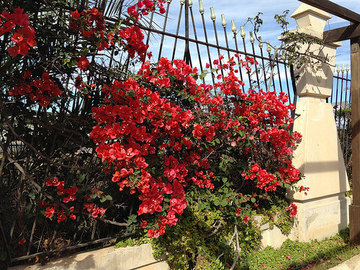

Um exemplo de uma foto presente no dataset de treino B, cujas fotos são tiradas por uma câmara dslr, é a foto apresentada seguidamente. É de notar que esta apresenta o ambiente secundário (fundo) desfocado, enquanto o foco principal está nítido.

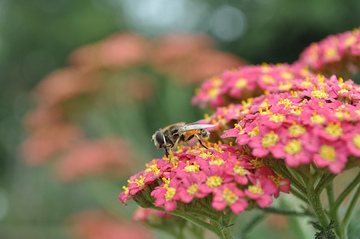

Primeiramente, foi utilizado o 'tf.data.Dataset.list_files' para criar um dataset de todos os ficheiros que correspondam a um pattern, que neste caso é "/path/*.jpg". Desta forma, criaram-se 4 datasets, um para o Train A (fotos iphone), Train B (fotos dslr), Test A e Test B. Posteriomente, foi verificado o número de imagens em cada dataset.

In [14]:
#Criar datasets de todos os ficheiros que correspondam a um pattern, nomeadamente "/path/*.jpg"
path_TrainA = tf.data.Dataset.list_files('/content/iphone2dslr_flower/trainA/*.jpg', shuffle=True)
path_TrainB = tf.data.Dataset.list_files('/content/iphone2dslr_flower/trainB/*.jpg', shuffle=True)
path_TestA = tf.data.Dataset.list_files('/content/iphone2dslr_flower/testA/*.jpg', shuffle=True)
path_TestB = tf.data.Dataset.list_files('/content/iphone2dslr_flower/testB/*.jpg', shuffle=True)
#Verificação do número de imagens em cada dataset
print('Número de imagens no dataset TrainA: ', len(path_TrainA))
print('Número de imagens no dataset TrainB: ', len(path_TrainB))
print('Número de imagens no dataset TestA: ', len(path_TestA))
print('Número de imagens no dataset TestB: ', len(path_TestB))

Número de imagens no dataset TrainA:  1812
Número de imagens no dataset TrainB:  3325
Número de imagens no dataset TestA:  569
Número de imagens no dataset TestB:  480


De modo a que as imagens tenham o formato (shape) certo para serem utilizadas na rede neuronal, transformou-se o dataset num Batchdataset, com buffer_size = 256 e batch_size = 1.

In [15]:
# batch images so they have the right shape for neural net
trainA = path_TrainA.cache().map(process_path_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
trainB = path_TrainB.cache().map(process_path_train, num_parallel_calls=tf.data.experimental.AUTOTUNE).shuffle(buffer_size).batch(batch_size)
testA = path_TestA.map(process_path_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)
testB = path_TestB.map(process_path_test, num_parallel_calls=tf.data.experimental.AUTOTUNE).cache().shuffle(buffer_size).batch(batch_size)

# Ver imagens

Aqui serão apresentadas amostras de fotos presentes no dataset de treino A e no dataset de treino B. Uma das fotos é uma amostra original e a outra é uma amostra com a aplicação de jitter aleatoriamente.

In [24]:
sample_trainA = next(iter(trainA))
sample_trainB = next(iter(trainB))

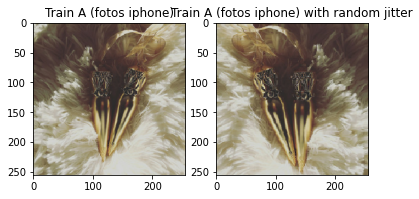

In [25]:
#Amostra (foto) original presente no dataset de treino A, referente às fotos do iphone
plt.subplot(121)
plt.title('Train A (fotos iphone)')
plt.imshow(sample_trainA[0] * 0.5 + 0.5)

#Amostra (foto) presente no dataset de treino A com random jitter
plt.subplot(122)
plt.title('Train A (fotos iphone) with random jitter')
plt.imshow(random_jitter(sample_trainA[0]) * 0.5 + 0.5)

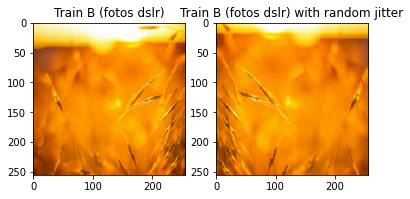

In [26]:
#Amostra (foto) presente no dataset de treino B, referente às fotos da dslr
plt.subplot(121)
plt.title('Train B (fotos dslr)')
plt.imshow(sample_trainB[0] * 0.5 + 0.5)

#Amostra (foto) presente no dataset de treino B com random jitter
plt.subplot(122)
plt.title('Train B (fotos dslr) with random jitter')
plt.imshow(random_jitter(sample_trainB[0]) * 0.5 + 0.5)

# Arquitetura 

### Opção 1 - Generator e discriminator Pix2Pix

Aqui foi utilizado o generator e o discriminator do pix2pix. A arquitetura aqui utilizada é bastante semelhante à utilizada no Pix2Pix (código fornecido pelo docente).

Instalar o [tensorflow_examples](https://github.com/tensorflow/examples) package que permite importar o generator e o discriminator.

In [27]:
!pip install -q git+https://github.com/tensorflow/examples.git

In [28]:
from tensorflow_examples.models.pix2pix import pix2pix

In [29]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


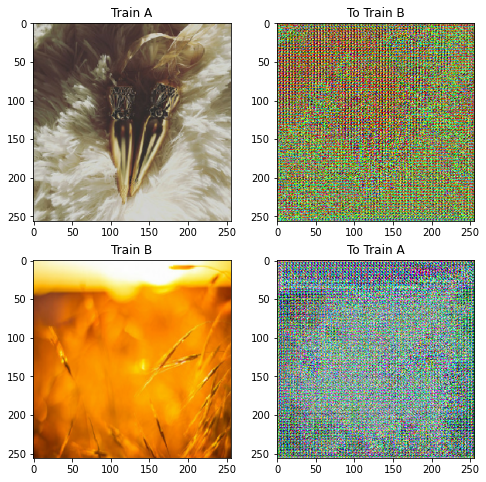

In [30]:
to_trainB = generator_g(sample_trainA)
to_trainA = generator_f(sample_trainB)
plt.figure(figsize=(8,8))
contrast = 8

imgs = [sample_trainA, to_trainB, sample_trainB, to_trainA]
title = ['Train A', 'To Train B', 'Train B', 'To Train A']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

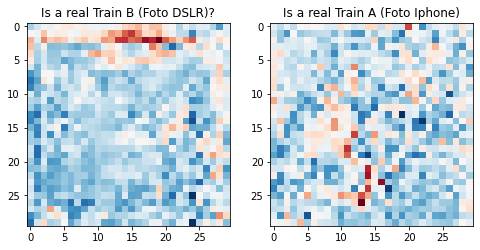

In [32]:
plt.figure(figsize=(8,8))

plt.subplot(121)
plt.title('Is a real Train B (Foto DSLR)?')
plt.imshow(discriminator_y(sample_trainB)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Train A (Foto Iphone)?')
plt.imshow(discriminator_x(sample_trainA)[0, ..., -1], cmap='RdBu_r')

plt.show()

### Opção 2 - Arquitetura UNET para a CycleGan

Utilizei a arquitetura UNET para a CycleGan. Para construir o generator, é necessário definir em primeiro lugar os métodos downsample e upsample.

#### Downsample

O downsample, como o nome indica, reduz as dimensões 2D, a largura e a altura, da imagem pela stride. A stride é o comprimento do passo que o filtro dá. Como a stride é 2, o filtro é aplicado a cada outro pixel, reduzindo assim o peso e a altura em 2.

In [23]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        #Utilização de uma instance normalization e não de uma batch normalization. 
        #Instance normalization não é padrão na API TensorFlow, pelo que é a utilizada a camada do TensorFlow Add-ons. 
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.LeakyReLU())

    return result

#### Upsample

O upsample, efetua o oposto do downsample, ou seja, aumenta as dimensões da imagem. Conv2DTranspose faz basicamente o oposto de uma camada Conv2D.

In [24]:
def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))
    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    if apply_dropout:
        result.add(layers.Dropout(0.5))

    result.add(layers.ReLU())

    return result

#### Construir o generator

Em primeiro lugar, o generator downsamples a imagem (reduz a resolução) utilizada como input e, em seguida, efetua upsample (aumenta a resolução) enquanto estabelece conexões de salto longas. As conexões de salto são uma maneira de ajudar a contornar o problema do vanishing gradient, concatenando o output de uma camada para várias camadas em vez de apenas uma. Aqui é concatenado o output da camada downsample para a camada upsample de forma simétrica.

In [25]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    # bs = batch size
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4), # (bs, 64, 64, 128)
        downsample(256, 4), # (bs, 32, 32, 256)
        downsample(512, 4), # (bs, 16, 16, 512)
        downsample(512, 4), # (bs, 8, 8, 512)
        downsample(512, 4), # (bs, 4, 4, 512)
        downsample(512, 4), # (bs, 2, 2, 512)
        downsample(512, 4), # (bs, 1, 1, 512)
    ]

    up_stack = [
        upsample(512, 4, apply_dropout=True), # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True), # (bs, 8, 8, 1024)
        upsample(512, 4), # (bs, 16, 16, 1024)
        upsample(256, 4), # (bs, 32, 32, 512)
        upsample(128, 4), # (bs, 64, 64, 256)
        upsample(64, 4), # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4, strides=2, padding='same', kernel_initializer=initializer, activation='tanh') # (bs, 256, 256, 3)

    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

#### Construir o discriminator

O discrimator recebe a imagem de entrada e classifica-a como real ou falsa (gerada). Em vez de gerar um único nó, o discriminator gera uma imagem 2D reduzida com valores de pixel mais altos, que indicam uma classificação real, e valores mais baixos, que indicam uma classificação falsa.

In [26]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, False)(x) # (bs, 128, 128, 64)
    down2 = downsample(128, 4)(down1) # (bs, 64, 64, 128)
    down3 = downsample(256, 4)(down2) # (bs, 32, 32, 256)

    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tfa.layers.InstanceNormalization(gamma_initializer=gamma_init)(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu) # (bs, 33, 33, 512)

    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

#### Gerar amostras

In [27]:
generator_g = Generator() 
generator_f = Generator() 

discriminator_x = Discriminator() 
discriminator_y = Discriminator() 

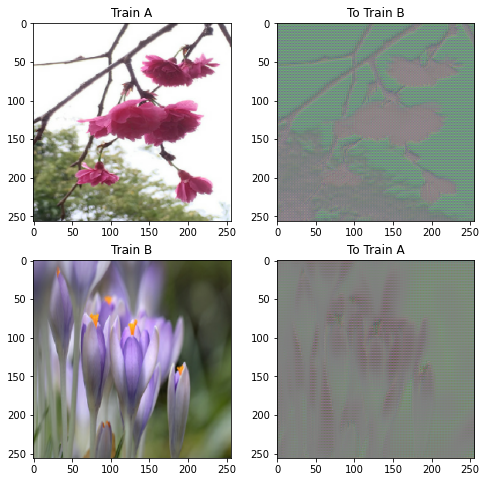

In [28]:
to_trainB = generator_g(sample_trainA)
to_trainA = generator_f(sample_trainB)
plt.figure(figsize=(8,8))
contrast = 8

imgs = [sample_trainA, to_trainB, sample_trainB, to_trainA]
title = ['Train A', 'To Train B', 'Train B', 'To Train A']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

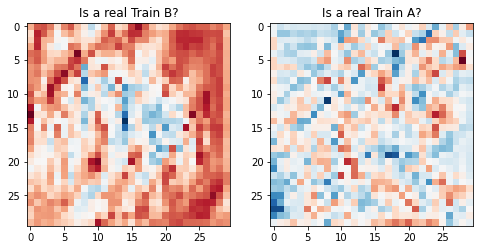

In [29]:
plt.figure(figsize=(8,8))

plt.subplot(121)
plt.title('Is a real Train B?')
plt.imshow(discriminator_y(sample_trainB)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is a real Train A?')
plt.imshow(discriminator_x(sample_trainA)[0, ..., -1], cmap='RdBu_r')

plt.show()

# Gerar Imagens


Para gerar as imagens utiliza-se a função seguinte. Esta função é utilizada após o run do modelo treinado no conjunto de dados de teste.

In [33]:
def generate_images(model, test_input, step = -1):
  prediction = model(test_input)
    
  fig1 = plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()
  if step != -1:
    fig1.savefig(f'cycle{step}.png')

# CycleGan 

O tf.keras.Model permite executar (run) a instrução fit() para treinar o nosso modelo. Durante a etapa de treino, o modelo transforma uma foto iphone para uma foto dsrl e depois de volta para uma foto iphone. A diferença entre a foto original e a foto duas vezes transformada é a cycle-consistency loss. As funções de loss são definidas posteriormente.


In [34]:
class CycleGan(keras.Model):
    def __init__(
        self,
        generator_g,
        generator_f,
        discriminator_x,
        discriminator_y,
    ):
        super(CycleGan, self).__init__()
        self.generator_g = generator_g
        self.generator_f = generator_f
        self.discriminator_x = discriminator_x
        self.discriminator_y = discriminator_y
        
    def compile(
        self,
        generator_g_optimizer,
        generator_f_optimizer,
        discriminator_x_optimizer,
        discriminator_y_optimizer,
        generator_loss,
        discriminator_loss,
        calc_cycle_loss,
        identity_loss
    ):
        super(CycleGan, self).compile()
        self.generator_g_optimizer = generator_g_optimizer
        self.generator_f_optimizer = generator_f_optimizer
        self.discriminator_x_optimizer = discriminator_x_optimizer
        self.discriminator_y_optimizer = discriminator_y_optimizer
        self.generator_loss = generator_loss
        self.discriminator_loss = discriminator_loss
        self.calc_cycle_loss = calc_cycle_loss
        self.identity_loss = identity_loss
        
    def train_step(self, batch_data):
        real_x, real_y = batch_data
        with tf.GradientTape(persistent=True) as tape:
          # Generator G translates X -> Y
          # Generator F translates Y -> X.
          
          fake_y = self.generator_g(real_x, training=True)
          cycled_x = self.generator_f(fake_y, training=True)

          fake_x = self.generator_f(real_y, training=True)
          cycled_y = self.generator_g(fake_x, training=True)

          # same_x and same_y are used for identity loss.
          same_x = self.generator_f(real_x, training=True)
          same_y = self.generator_g(real_y, training=True)

          disc_real_x = self.discriminator_x(real_x, training=True)
          disc_real_y = self.discriminator_y(real_y, training=True)

          disc_fake_x = self.discriminator_x(fake_x, training=True)
          disc_fake_y = self.discriminator_y(fake_y, training=True)

          # calculate the loss
          gen_g_loss = self.generator_loss(disc_fake_y)
          gen_f_loss = self.generator_loss(disc_fake_x)
          
          total_cycle_loss = self.calc_cycle_loss(real_x, cycled_x) + self.calc_cycle_loss(real_y, cycled_y)
          
          # Total generator loss = adversarial loss + cycle loss
          total_gen_g_loss = gen_g_loss + total_cycle_loss + self.identity_loss(real_y, same_y)
          total_gen_f_loss = gen_f_loss + total_cycle_loss + self.identity_loss(real_x, same_x)

          disc_x_loss = self.discriminator_loss(disc_real_x, disc_fake_x)
          disc_y_loss = self.discriminator_loss(disc_real_y, disc_fake_y)
        
        # Calculate the gradients for generator and discriminator
        generator_g_gradients = tape.gradient(total_gen_g_loss, self.generator_g.trainable_variables)
        generator_f_gradients = tape.gradient(total_gen_f_loss, self.generator_f.trainable_variables)
        discriminator_x_gradients = tape.gradient(disc_x_loss, self.discriminator_x.trainable_variables)
        discriminator_y_gradients = tape.gradient(disc_y_loss, self.discriminator_y.trainable_variables)
        
        # Apply the gradients to the optimizer
        self.generator_g_optimizer.apply_gradients(zip(generator_g_gradients, self.generator_g.trainable_variables))
        self.generator_f_optimizer.apply_gradients(zip(generator_f_gradients, self.generator_f.trainable_variables))
        self.discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients, self.discriminator_x.trainable_variables))
        self.discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients, self.discriminator_y.trainable_variables))

        return {
                  "G_loss": total_gen_g_loss,
                  "F_loss": total_gen_f_loss,
                  "D_X_loss": disc_x_loss,
                  "D_Y_loss": disc_y_loss,
        }


# Funções Loss

In [35]:
LAMBDA = 10

In [36]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator

O discriminator deve prever 1s para imagens reais e 0s para imagens falas. A discriminator loss é a média da loss real e gerada.

In [37]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)
  generated_loss = loss_obj(tf.zeros_like(generated), generated)
  total_disc_loss = real_loss + generated_loss
  return total_disc_loss * 0.5

### Generator

In [43]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

Queremos que a foto original e a foto duas vezes transformada sejam semelhantes. Assim, podemos calcular a cycle consistency loss e encontrar a média da sua diferença.

In [44]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  return LAMBDA * loss1

A identity loss compara a imagem com o seu generator (ou seja, foto obtida com generator de foto). A identity loss compara o input com o output do generator.

In [45]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [46]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

# Treino

In [47]:
cycle_gan_model = CycleGan(generator_g, generator_f, discriminator_x, discriminator_y)

In [48]:
cycle_gan_model.compile(
        generator_g_optimizer = generator_g_optimizer,
        generator_f_optimizer = generator_f_optimizer,
        discriminator_x_optimizer = discriminator_x_optimizer,
        discriminator_y_optimizer = discriminator_y_optimizer,
        generator_loss = generator_loss,
        discriminator_loss = discriminator_loss,
        calc_cycle_loss = calc_cycle_loss,
        identity_loss = identity_loss
    )

O modelo é treinado com 10 epochs, devido à demora para obter previsões. Utilizei a GPU, mas mesmo assim estava muito lento. É de notar que as previsões obtidas com 10 epochs são menos precisas.

In [ ]:
cycle_gan_model.fit(tf.data.Dataset.zip((trainA, trainB)), epochs=10)

In [ ]:
# Run the trained model on the test dataset
for inp in testA.take(3):
  generate_images(generator_g, inp)

# Resultados Obtidos

## Arquitetura com generator e discriminator do Pix2Pix

Através da arquitetura constituída com o generator e discriminator do Pix2Pix, foram obtidos os seguintes resultados:

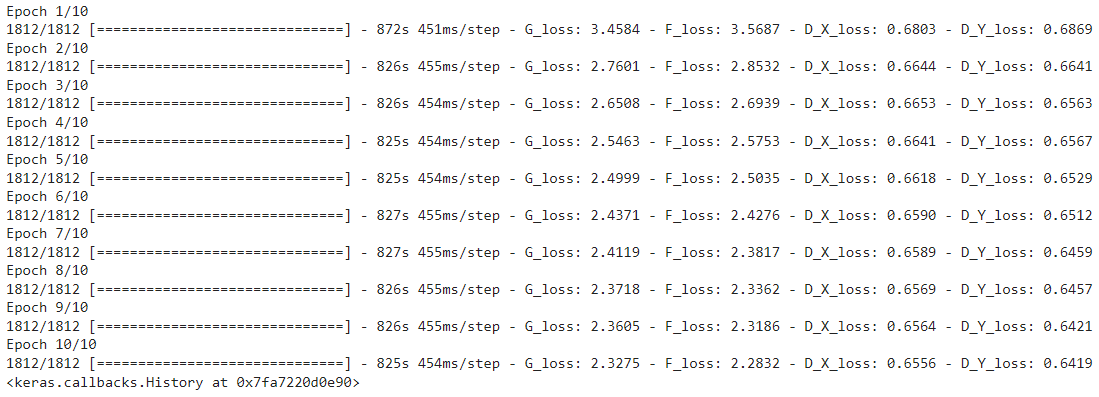

Na figura acima, podemos observar que a loss do generator e do discriminator vão diminuindo ao longo das ephocs. Como já havia sido mencionado, aqui foram utilizadas apenas 10 epochs devido à lentidão na obtenção das previsões, sendo que cada epoch demora um total de 451ms/step. Desta forma, a G_loss (generator g) é de 2.3275, a F_loss (generator f) é de 2.2832, a D_x_loss (discriminator x) é de 0.6556 e a D_y_loss é de 0.6419 (discriminator y).

A figura seguinte corresponde às predicted images com base nas imagens utilizadas como input. Estas imagens/fotos utilizadas como input estão presentes no dataset de teste A. Nesta figura é possível observar que as imagens previstas comparativamente às imagens de entrada contêm um fundo mais desfocado, dando ênfase à parte considerada principal, ou seja, o foco princial da imagem está consideravelmente nítido. É de notar que devido às 10 epochs, as imagens previstas não são tão precisas como gostaria que fossem, sendo que a precisão das mesmas aumentaria consoante o número de epochs.

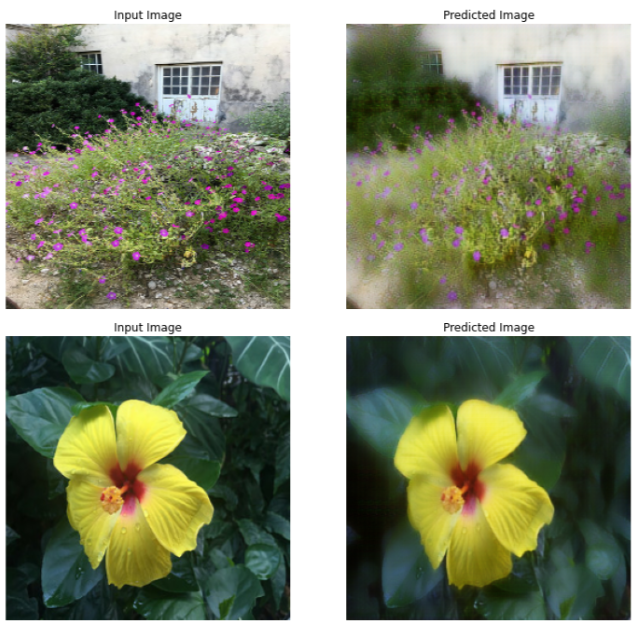

## Arquitetura UNET

Através da arquitetura UNET foram obtidos os seguintes resultados:

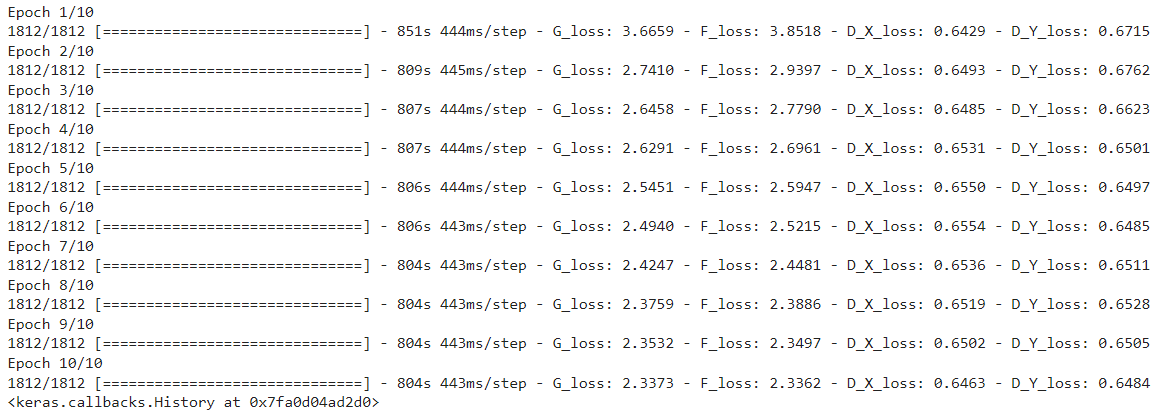

Na figura acima, tal como acontece na primeira arquitetura apresentada, podemos observar que a loss do generator e do discriminator vão diminuindo ao longo das ephocs. Como já havia sido mencionado, aqui foram utilizadas apenas 10 epochs devido à lentidão na obtenção das previsões, sendo que cada epoch demora um total de 444ms/step. Desta forma, a G_loss (generator g) é de 2.3373, a F_loss (generator f) é de 2.3362, a D_x_loss (discriminator x) é de 0.6463 e a D_y_loss é de 0.6484 (discriminator y).

A figura seguinte corresponde às predicted images com base nas imagens utilizadas como input. Estas imagens/fotos utilizadas como input estão presentes no dataset de teste A. Nesta figura é possível observar que as imagens previstas comparativamente às imagens de entrada contêm um fundo mais desfocado, dando ênfase à parte considerada principal, ou seja, o foco princial da imagem está consideravelmente nítido. É de notar que devido às 10 epochs, as imagens previstas não são tão precisas como gostaria que fossem, sendo que a precisão das mesmas aumentaria consoante o número de epochs.

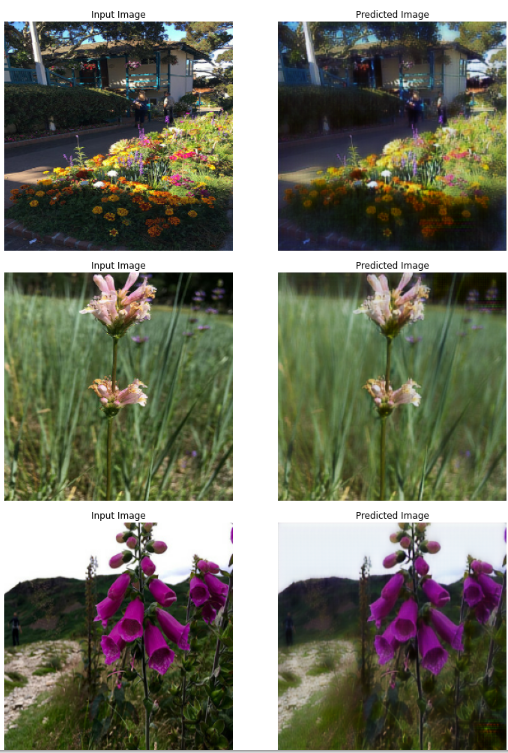

Comparando as duas arquiteturas e tendo em consideração a utilização do mesmo número de epochs no treino de ambas, podemos concluir que os resultados não apresentam diferenças significativas, sendo estes bastante similares. No entanto, para este teste, é possível observar que a primeira arquitetura obteve melhores resultados no que diz respeito à loss do generator G e do generator F, enquanto a segunda arquitetura obteve melhores resultados no que diz respeito à loss do discriminator x e do discriminator y. É de notar que devido aos valores de loss obtidos nas duas arquiteturas serem tão próximos, o que foi dito na frase anterior pode não acontecer sempre, ou seja, caso se faça outro teste o que foi referido pode já não ser viável. Em relação às predicted imagens obtidas a partir das duas arquiteturas, é possível observar que visualmente estas apresentam alguma diferença, sendo que nas predicted images da segunda arquitetura o fundo está desfocado de forma mais 'smooth' e o foco principal está mais nítido comparativamente às predicted images obtidas por meio da primeira arquitetura. 


# Comparação com outros resultados/trabalhos


No Kaggle quase não existem trabalhos que têm como base o dataset aqui escolhido para aplicação de CycleGan. Por esse motivo, a comparação de resultados/trabalhos vai ter como base também artigos e projetos presentes no github.

O trabalho de Junyan Zhu, Taesung Park, Phillip Isola e Alexei Efros, que pode ser encontrado em [https://taesung.me/cyclegan/2017/03/25/iphone-to-dslr-flower-best.html](https://taesung.me/cyclegan/2017/03/25/iphone-to-dslr-flower-best.html) e/ou [https://junyanz.github.io/CycleGAN/](https://junyanz.github.io/CycleGAN/), obteve ótimos resultados, ou seja, conseguiram converter de forma excecional fotos tiradas com o iphone em fotos tiradas com a câmara dsrl. 


Considerando a imagem de entrada (input) seguinte, vou comparar a predicted image obtida pelos autores referidos anteriormente com a predicted image obtida no meu projeto.

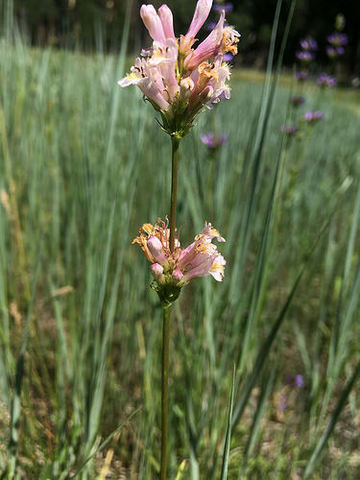

A predicted image obtida pelos autores mencionados anteriormente é a seguinte:

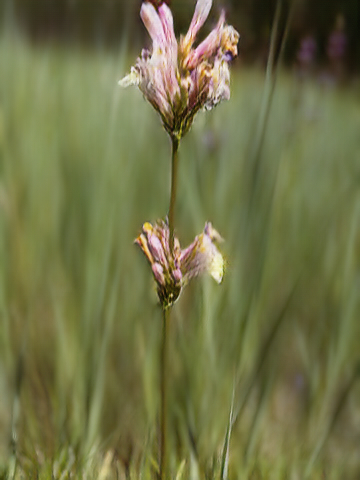

A predicted image obtida no meu projeto é a seguinte:

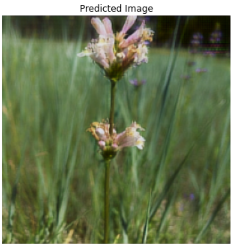

Com base nas duas figuras anteriores, é possível observar uma grande diferença entre as duas, sendo que a predicted image obtida pelos autores mencionados anteriormente apresenta características de fotos dsrl mais precisas e notáveis do que a predicted image obtida neste projeto. Um dos motivos para essa diferença é o facto de estar a utilizar um número de epochs consideralmente diminuto, fazendo com que as predicted images obtidas sejam menos precisas do que as obtidas com maior número de epochs.

Segundo o artigo elaborado pelos autores mencionados anteriormente, [https://www.researchgate.net/publication/322060135_Unpaired_Image-to-Image_Translation_Using_Cycle-Consistent_Adversarial_Networks](https://www.researchgate.net/publication/322060135_Unpaired_Image-to-Image_Translation_Using_Cycle-Consistent_Adversarial_Networks), os autores aplicaram às imagens uma scale para 360 pixels de largura. Foi utilizada também a identity mapping loss com um peso de 0,5. O tamanho do conjunto de treino (training set) do iphone e do dataset DSLR era de 1813 e 3326, respectivamente.